In [1]:
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.decomposition import PCA
import scipy.spatial.distance as sdist

In [2]:
data = pd.read_csv("TP1_data.csv", index_col=0)
X = data.drop("classe", 1)
y = data.classe
df = pd.concat([X, y], axis = 1)

## 1. Représentation des données :
(a) En visualisant puis en évaluant quantitativement les relations de corrélation entre les 4
variables de représentation, déterminez s’il est nécessaire d’appliquer une transformation
des variables basée sur l’analyse des composantes principales (ACP). Les relations de
corrélation entre les variables sont-elles similaires pour toutes les 3 classes ?


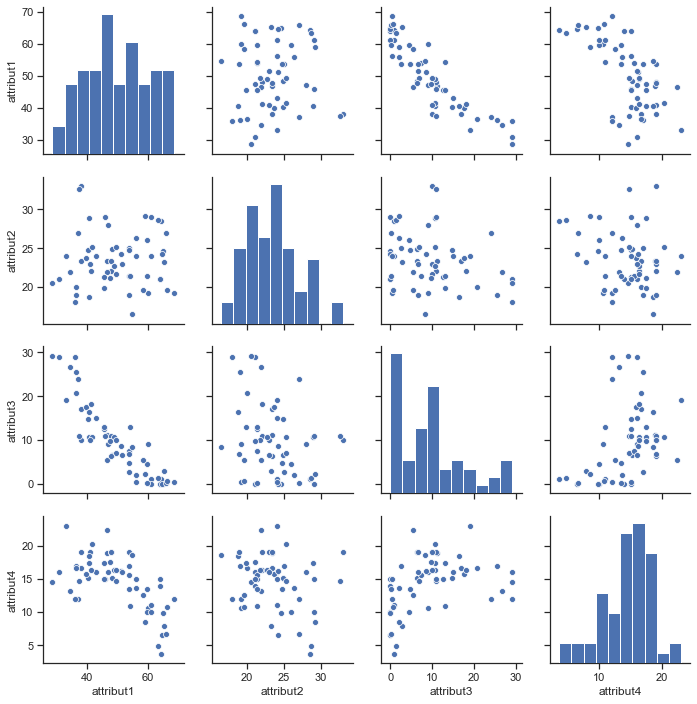

In [3]:
sns.pairplot(X)

Les attributs 1 et 3 semblent corrélés. 

On peut le confirmer avec une mesure de corrélation de Pearson:

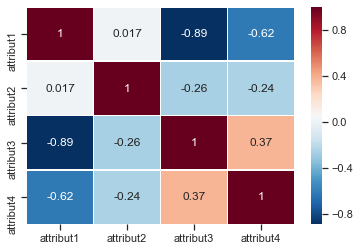

In [4]:
pearson_corr = X.corr(method='pearson')

sns.heatmap(pearson_corr, 
            xticklabels=pearson_corr.columns,
            yticklabels=pearson_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

On peut confirmer avec ces graphes qu'il y a effectivement une corrélation légère entre les attributs 1 et 3.

On s'intéresse maintenant au lien, s'il existe, entre la classe et la corrélation des différents attributs:

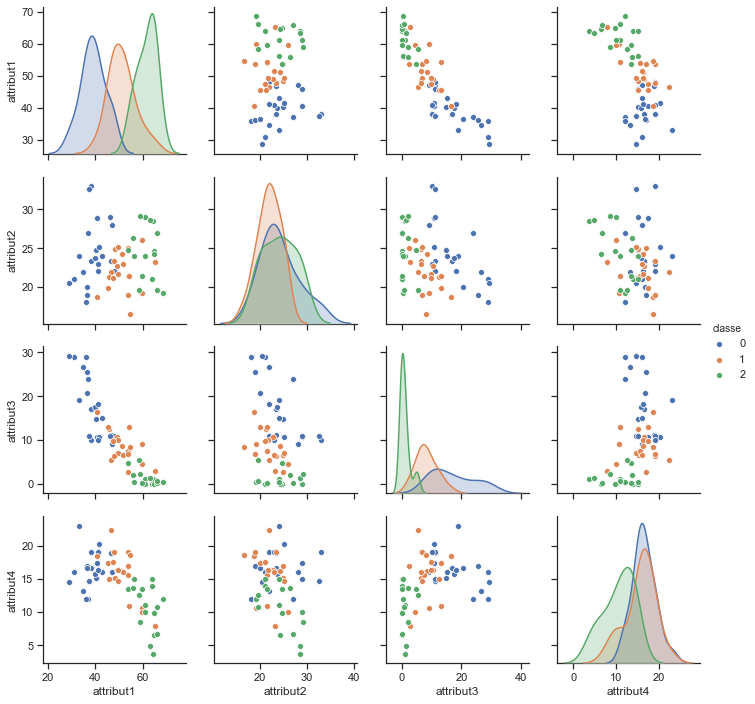

In [4]:
sns.pairplot(df, hue='classe', vars=X)

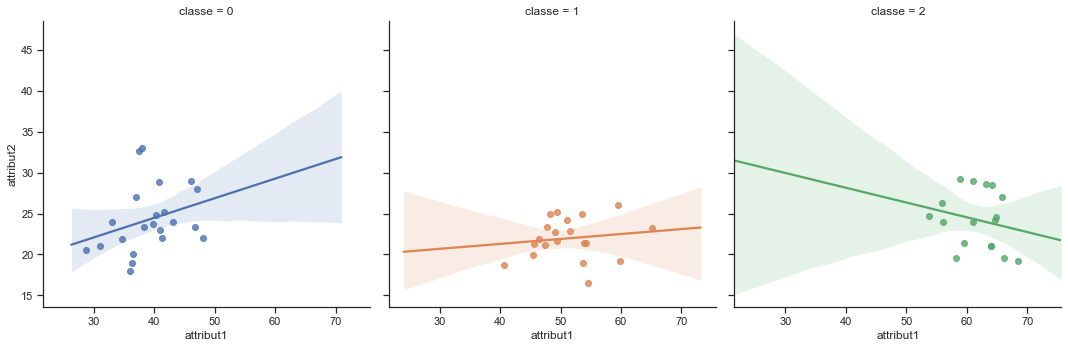

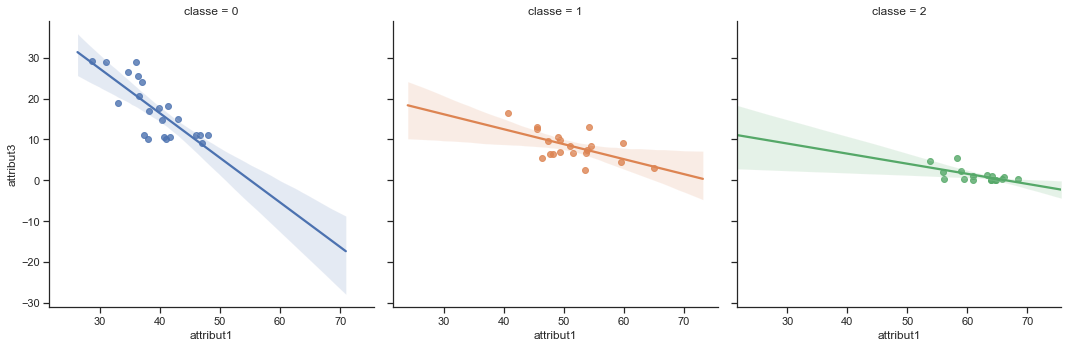

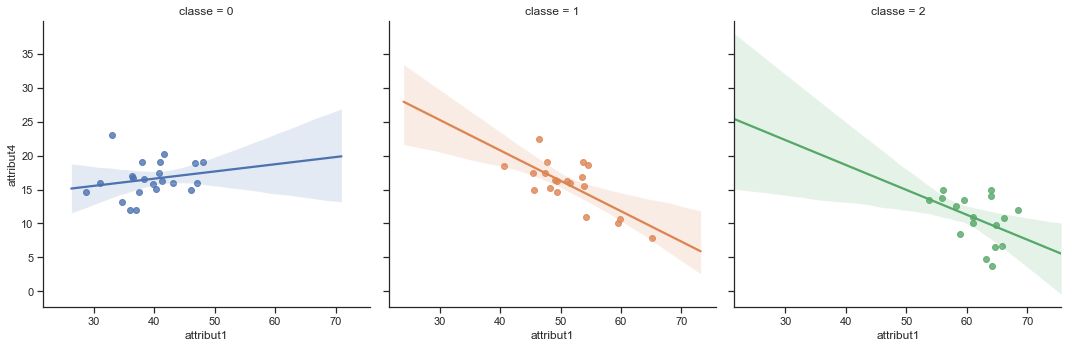

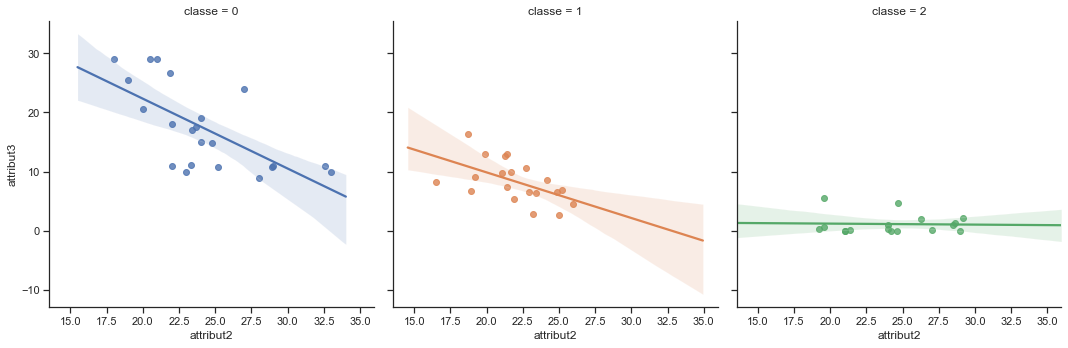

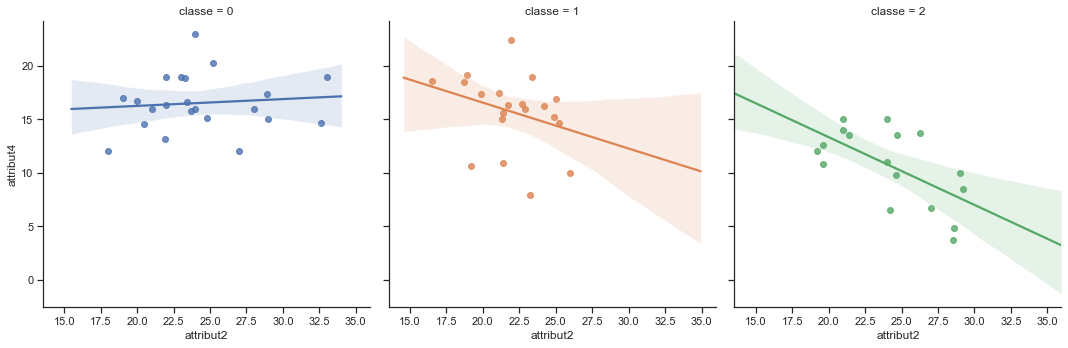

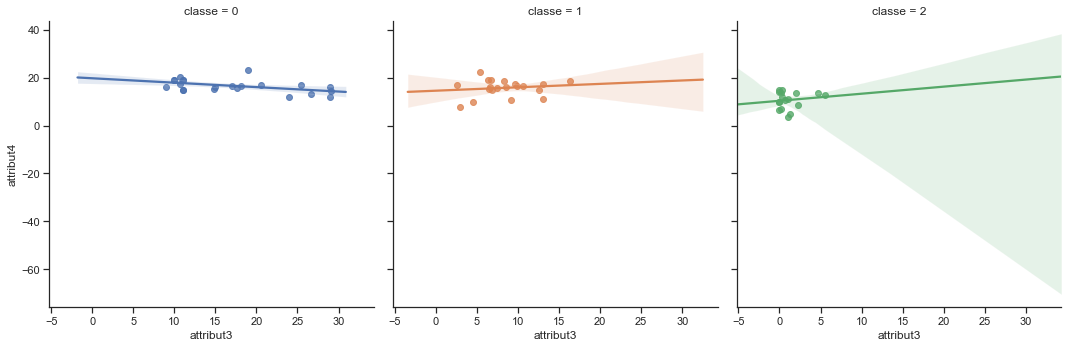

In [11]:
########################### TODO : plot en grid ####################################
plots = set()
for X_i in X.columns:
    cols = X.columns.drop(X_i)
    for X_j in cols:
        if frozenset({X_i, X_j}) not in plots:
            sns.lmplot(x=X_i, y=X_j, data=df, col='classe', hue='classe')
        plots.add(frozenset({X_i, X_j}))

(b) En visualisant la séparation entre les 3 classes après transformation par ACP, déterminez
un nombre optimal de composantes principales (CP) à utiliser pour la classification :
2CP ou 3CP. Vérifiez votre réponse en calculant, pour chaque objet, le centroïde dont
il est le plus proche par la distance (Euclidienne) dans les cas 2CP et 3CP, puis en
comparant avec les classes réelles des objets.

Application des ACP pour 2CP et 3CP:

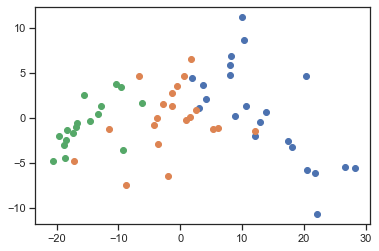

In [15]:
pca_2CP = PCA(n_components=2).fit(X)
pca_2CP_c = {}
for y_i in y.unique():
    pca_2CP_c[y_i] = pca_2CP.transform(df.loc[df['classe'] == y_i].drop('classe', 1))
    plt.scatter(pca_2CP_c.get(y_i)[:,0], pca_2CP_c.get(y_i)[:,1])
pca_2CP = pca_2CP.transform(X)


In [4]:
pca_3CP = PCA(n_components=3).fit(X)
pca_3CP_c = {}
for y_i in y.unique():
    pca_3CP_c[y_i] = pca_3CP.transform(df.loc[df['classe'] == y_i].drop('classe', 1))
pca_3CP = pca_3CP.transform(X)


Calcul des centroïdes pour 2CP:

In [23]:
centroids_2CP = {}
for i, pca_c in pca_2CP_c.items():
    centroids_2CP[i] = pca_c.mean(axis=0)

Calcul moyenne distance entre points et centroïdes et nombre d'erreurs de classification:

In [34]:
mean_dist_2CP = {}
errors_2CP = {}

for i, pca_c in pca_2CP_c.items():
    min_dist = []
    errors_2CP[i] = 0
    for j, point in enumerate(pca_c):
        dist_to_centroids = [sdist.euclidean(point, centroids_2CP.get(i)) for j in range(len(centroids_2CP))]
        min_dist, y_min_dist = min(dist_to_centroids), dist_to_centroids.index(min(dist_to_centroids))
        if y_min_dist != y[i]:
            errors_2CP[i] += 1
        mean_dist_2CP[i] = np.mean(min_dist)
    print("Classe", i," - Distance moyenne:", mean_dist_2CP.get(i), " - Nombre erreurs :", errors_2CP.get(i))

Classe 0  - Distance moyenne: 5.356922390446231  - Nombre erreurs : 0
Classe 1  - Distance moyenne: 4.342460781842362  - Nombre erreurs : 0
Classe 2  - Distance moyenne: 6.5384040602555755  - Nombre erreurs : 0


Calcul des centroïdes pour 3CP:

In [5]:
centroids_3CP = {}
for i, pca_c in pca_3CP_c.items():
    centroids_3CP[i] = pca_c.mean(axis=0)

Calcul moyenne distance entre points et centroïdes et nombre d'erreurs de classification:

In [36]:
mean_dist_3CP = {}
errors_3CP = {}

for i, pca_c in pca_3CP_c.items():
    min_dist = []
    errors_3CP[i] = 0
    for j, point in enumerate(pca_c):
        dist_to_centroids = [sdist.euclidean(point, centroids_3CP.get(i)) for j in range(len(centroids_3CP))]
        min_dist, y_min_dist = min(dist_to_centroids), dist_to_centroids.index(min(dist_to_centroids))
        if y_min_dist != y[i]:
            errors_3CP[i] += 1
        mean_dist_3CP[i] = np.mean(min_dist)
    print("Classe", i," - Distance moyenne:", mean_dist_3CP.get(i), " - Nombre erreurs :", errors_3CP.get(i))

Classe 0  - Distance moyenne: 5.882605027613758  - Nombre erreurs : 0
Classe 1  - Distance moyenne: 4.544578971802466  - Nombre erreurs : 0
Classe 2  - Distance moyenne: 7.505394920014758  - Nombre erreurs : 0


Par l'utilisation de 3 composantes principales, il y a une minimisation légère de la distance 
moyenne entre les points et leur centroïde de classe correspondant. On peut dont envisager continuer
avec une réduction à 3 CP.  

## 2. Mesure de distance :
(a) D’après les résultats sur l’analyse de corrélation entre les variables de représentation
(1.(a)), quelle mesure de distance (Manhattan, Euclidienne, ou Mahalanobis) entre les
objets serait la plus adéquate ? Vérifiez votre réponse en calculant pour chacune des
mesures de distance, le centroïde le plus proche de chaque objet, puis en comparant avec
les classes réelles des objets.

Nous avons pu effectuer les calculs dans le cas de l'utilisation d'une mesure de 
distance Euclidienne. On s'intéresse maintenant à la mesure de distance Manhattan et Mahalanobis:

In [6]:
def compute_manhattan(pca, centroids, labels):
    errors = 0
    for i, point in enumerate(pca):
        dist = [sdist.cityblock(point, centroids[j]) for j in range(len(centroids))]
        y_min_dist = dist.index(min(dist))
        if y_min_dist != labels[i]:
            errors += 1
    return min(dist), errors

In [7]:
def compute_mahalanobis(pca, centroids, labels, cov_matrix):
    errors = 0
    for i, point in enumerate(pca):
        dist = [sdist.mahalanobis(point, centroids[j], cov_matrix) for j in range(len(centroids))]
        y_min_dist = dist.index(min(dist))
        if y_min_dist != labels[i]:
            errors += 1
    return min(dist), errors

In [8]:
def compute_covariance(data):
    return sp.linalg.inv(np.cov(data.T))

In [15]:
errors_man = {}
errors_mah = {}
dist_man = {}
dist_mah = {}
cov_pca_3CP = compute_covariance(pca_3CP)

for i, pca_c in pca_3CP_c.items():
    dist_man[i],  errors_man[i] = compute_manhattan(pca_c, centroids_3CP, y)
    dist_mah[i],  errors_mah[i] = compute_mahalanobis(pca_c, centroids_3CP, y, cov_pca_3CP)
    print("Manhattan - classe", i, " - distance moyenne :", np.mean(dist_man[i]), 
          " - nombre d'erreurs:", errors_man[i])
    print("Mahalanobis - classe", i, " - distance moyenne :", np.mean(dist_mah[i]), 
          " - nombre d'erreurs:", errors_mah[i], "\n")

Manhattan - classe 0  - distance moyenne : 9.93880469104534  - nombre d'erreurs: 4
Mahalanobis - classe 0  - distance moyenne : 1.0607504813808228  - nombre d'erreurs: 3 

Manhattan - classe 1  - distance moyenne : 6.553176927520406  - nombre d'erreurs: 19
Mahalanobis - classe 1  - distance moyenne : 0.533375651616391  - nombre d'erreurs: 20 

Manhattan - classe 2  - distance moyenne : 11.594483473491701  - nombre d'erreurs: 17
Mahalanobis - classe 2  - distance moyenne : 1.0321245578103087  - nombre d'erreurs: 17 



On remarque que le distance moyenne entre le centre du centroïde et les points est extrêmement
réduit par l'utilisation de la mesure de distance Mahalanobis.  

(b) Pour la distance de Mahalanobis, on peut utiliser une matrice de covariance par classe
ou une matrice de covariance pour toutes les données. Laquelle des deux options est la
plus adéquate ?

Si les distributions des données sont différentes selons les classes, il est plus 
intéressant de calculer une matrice de covariance pour chaque classe et ainsi calculer la distance
moyenne entre le centre du centroïde et les points de cette classe. 
Nous allons voir si cela s'applique à notre jeu de données:

In [16]:
errors_mah = {}
dist_mah = {}

for i, pca_c in pca_3CP_c.items():
    dist_mah[i],  errors_mah[i] = compute_mahalanobis(pca_c, centroids_3CP, y,
                                                                 compute_covariance(pca_c))
    print("Mahalanobis - classe", i, " - distance moyenne :", np.mean(dist_mah[i]), 
          " - nombre d'erreurs:", errors_mah[i])

Mahalanobis - classe 0  - distance moyenne : 1.0263142214021417  - nombre d'erreurs: 2
Mahalanobis - classe 1  - distance moyenne : 0.6848606557576434  - nombre d'erreurs: 19
Mahalanobis - classe 2  - distance moyenne : 1.8479939757742574  - nombre d'erreurs: 17


## 3. Choix du modèle de classification :
(a) En utilisant la meilleure représentation des données retenue au Point 1, et la meilleure
mesure de distance retenue au Point 2, tester la méthode des k = 5 plus proches voisins
ou la méthode du plus proche centroïde, et déterminez la plus adéquate.

(b) On fait l’hypothèse que les objets correspondent à des mélanges de distributions gaussiennes correspondant aux classes. Déterminez si cette hypothèse est vraissemblable en
appliquant une classification par modèle de mélange gaussien ("Gaussian Mixture Model”) aux données. Justifiez votre choix parmi les quatre options du modèle pour la
covariance des différentes classes (spherical, diag, tied, ou full).

## 4. Application :
À l’aide du modèle retenue au Point 3., déterminez la classe de la nouvelle
observation suivante : [52.1, 23.0, 6.1, 16.5]
